In [1]:
import os
import sys

import math
from datetime import timezone, datetime

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import mplfinance as mpf
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [2]:
# TimescaleDB用のユーティリティライブラリの設定
from timescaledb_util import TimeScaleDBUtil

_pg_config = {
        'user': os.environ['POSTGRES_USER'],
        'password': os.environ['POSTGRES_PASSWORD'],
        'host': os.environ['POSTGRES_HOST'],
        'port': os.environ['POSTGRES_PORT'],
        'database': os.environ['POSTGRES_DATABASE']
    }
    
_dbutil = TimeScaleDBUtil(user = _pg_config['user'], password = _pg_config['password'], host = _pg_config['host'], port = _pg_config['port'], database = _pg_config['database'])

In [3]:
# 学習区間のドルバーの読み込みと保存
df_dollar = _dbutil.read_sql_query(sql = "SELECT * FROM \"ftx_btc-perp_dollarbar_10000000\" WHERE datetime >= '2020-01-01 00:00:00.000+00' AND datetime < '2022-01-01 00:00:00.000+00' ORDER BY dollar_cumsum ASC")
df_dollar = df_dollar[['datetime', 'datetime_from', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'dollar_cumsum']]
df_dollar['fee'] = 0.02 / 100.0
df_dollar['delta_time'] = df_dollar['datetime'].diff()
df_dollar = df_dollar.dropna()
df_dollar = df_dollar[['datetime', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee']]
df_dollar = df_dollar.dropna()
df_dollar.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee']
df_dollar = df_dollar.set_index("Datetime")
df_dollar.to_pickle('df_dollar_10000000_ohlcv_learn.pkl')

# バリデーション区間のドルバーの読み込みと保存
df_dollar_validation = _dbutil.read_sql_query(sql = "SELECT * FROM \"ftx_btc-perp_dollarbar_10000000\" WHERE datetime >= '2022-01-01 00:00:00.000+00' AND datetime < '2023-01-01 00:00:00.000+00' ORDER BY dollar_cumsum ASC")
df_dollar_validation = df_dollar_validation[['datetime', 'datetime_from', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'dollar_cumsum']]
df_dollar_validation['fee'] = 0.02 / 100.0
df_dollar_validation = df_dollar_validation[['datetime', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee']]
df_dollar_validation = df_dollar_validation.dropna()
df_dollar_validation.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee']
df_dollar_validation = df_dollar_validation.set_index("Datetime")
df_dollar_validation.to_pickle('df_dollar_10000000_ohlcv_validation.pkl')

display(df_dollar)
#mpf.plot(df_dollar, volume=False, figratio=(12, 6))

,Open,High,Low,Close,dollar_volume,dollar_buy_volume,dollar_sell_volume,dollar_liquidation_buy_volume,dollar_liquidation_sell_volume,fee
Datetime,,,,,,,,,,
2020-01-01 11:33:40.515000+00:00,7201.00,7222.00,7155.25,7209.00,9.978019e+06,5.416686e+06,4.561333e+06,943.907000,24705.544850,0.0002
2020-01-01 15:36:22.055000+00:00,7209.75,7215.75,7163.50,7211.00,1.002515e+07,5.144728e+06,4.880425e+06,0.000000,0.000000,0.0002
2020-01-01 22:13:28.678000+00:00,7211.25,7237.50,7189.00,7200.50,1.000382e+07,5.364796e+06,4.639020e+06,7.955475,2367.862550,0.0002
2020-01-02 02:03:29.592000+00:00,7199.25,7204.50,7129.00,7138.50,9.874773e+06,3.642596e+06,6.232177e+06,0.000000,10413.467425,0.0002
2020-01-02 03:36:53.563000+00:00,7138.50,7145.25,7125.25,7131.25,1.007798e+07,5.554273e+06,4.523711e+06,0.000000,3930.450700,0.0002
...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:30:43.875000+00:00,46414.00,46478.00,46355.00,46398.00,9.962268e+06,4.169872e+06,5.792397e+06,0.000000,0.000000,0.0002
2021-12-31 23:40:19.242000+00:00,46398.00,46514.00,46374.00,46392.00,9.999434e+06,5.691469e+06,4.307965e+06,0.000000,0.000000,0.0002
2021-12-31 23:46:53.601000+00:00,46392.00,46507.00,46392.00,46413.00,1.003758e+07,5.503301e+06,4.534281e+06,0.000000,0.000000,0.0002


In [4]:
# Richmanbtc産のチュートリアルから取った関数
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

def calc_buysell(df, pips = 1, atr_mux = 0.5):
    # ATRで指値距離を計算します
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    limit_price_dist = df['ATR'] * atr_mux
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips
    
    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['Close'] - limit_price_dist
    df['sell_price'] = df['Close'] + limit_price_dist
    
    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['Low'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['High'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1
    
    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料
    
    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['Low'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['High'].shift(-1) / pips).round()).astype('float64')
    
    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['Close'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['Close'] - 1) + fee,
        0
    )
    
    return df

In [5]:
import optuna
import math

# ATRの指値幅を変数として、取引数とリターンの積を最大化するOptunaの最適化対象の関数
def target_function(x):
    df_dollar = pd.read_pickle('df_dollar_10000000_ohlcv_learn.pkl')
    df_dollar = calc_buysell(df_dollar, pips = 1, atr_mux = x)
    y_buy = df_dollar['y_buy'].sum()
    buy_count = len(df_dollar[df_dollar['buy_executed'] == True])
    y_sell = df_dollar['y_sell'].sum()
    sell_count = len(df_dollar[df_dollar['sell_executed'] == True])
    #print(f'atr_mux = {x}, y_buy = {y_buy}, y_sell = {y_sell}, y_sum = {y_sum}')
    return y_buy * math.pow(buy_count, 1) + y_sell * math.pow(sell_count, 1)

# Optunaの最適化目的関数
def objective(trial):
    x = trial.suggest_uniform('x', 1.0, 4.0)
    score = target_function(x)
    return score

# 最適化を実施
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=100)
#optuna.visualization.plot_slice(study, params=["x"])
#atr_mux = study.best_params['x']

# 以前の学習結果を利用して最適化をスキップ
# Trial 74 finished with value: 16193.839450781088 and parameters: {'x': 1.4788760220633528}. Best is trial 74 with value: 16193.839450781088
atr_mux = 1.4788760220633528

In [6]:
# パフォーマンスを表示する関数
def display_performance(df_dollar, subtitle):
    print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
    plt.figure(figsize=(12,6))
    ax = plt.subplot(121)
    df_dollar['buy_executed'].rolling(1000).mean().plot(label='Buy', ax=ax)
    df_dollar['sell_executed'].rolling(1000).mean().plot(label='Sell', ax=ax)
    plt.title(f'Execution probability ({subtitle})')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

    print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
    plt.figure(figsize=(12,6))
    ax = plt.subplot(121)
    df_dollar['buy_fet'].rolling(1000).mean().plot(label='Buy')
    df_dollar['sell_fet'].rolling(1000).mean().plot(label='Sell')
    plt.title(f'Average time until exit ({subtitle})')
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.show()

    plt.figure(figsize=(12,6))
    ax = plt.subplot(121)
    df_dollar['buy_fet'].hist(alpha=0.3, label='Buy')
    df_dollar['sell_fet'].hist(alpha=0.3, label='Sell')
    plt.title(f'Time distribution until exit ({subtitle})')
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.show()

    print('毎時刻、この執行方法でトレードした場合の累積リターン')
    plt.figure(figsize=(12,6))
    ax = plt.subplot(121)
    df_dollar.loc[:, 'y_buy_executed'] = df_dollar['y_buy']
    df_dollar.loc[df_dollar['buy_executed'] <= 0.0, 'y_buy_executed'] = 0.0
    df_dollar.loc[:, 'y_sell_executed'] = df_dollar['y_sell']
    df_dollar.loc[df_dollar['sell_executed'] <= 0.0, 'y_sell_executed'] = 0.0
    
    df_dollar['y_buy_executed'].cumsum().plot(label='Buy')
    df_dollar['y_sell_executed'].cumsum().plot(label='Sell')
    (df_dollar['y_buy_executed'] + df_dollar['y_sell_executed']).cumsum().plot(label='Buy+Sell')
    plt.title(f'Cumulative return ({subtitle})')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

    print(f'買いリターン {df_dollar["y_buy_executed"].sum()*100:.2f}% 売りリターン {df_dollar["y_sell_executed"].sum()*100:.2f}% 合計リターン {(df_dollar["y_buy_executed"].sum() + df_dollar["y_sell_executed"].sum())*100:.2f}%')
    print(f'バーの数 {len(df_dollar)}本, 買い {len(df_dollar[(df_dollar["buy_executed"]==1.0)])}回, 売り {len(df_dollar[(df_dollar["sell_executed"]==1.0)])}回, 買った時のリターン平均 {df_dollar.loc[df_dollar["buy_executed"] > 0, "y_buy_executed"].mean()*100:.03f} %, 売った時のリターン平均 {df_dollar.loc[df_dollar["sell_executed"] > 0, "y_sell_executed"].mean()*100:.03f} %')
    print(f'リターンが0以上になる率 {(len(df_dollar[df_dollar["y_buy_executed"] > 0]) + len(df_dollar[df_dollar["y_sell_executed"] > 0])) / (len(df_dollar[(df_dollar["buy_executed"] > 0)]) + len(df_dollar[(df_dollar["sell_executed"] > 0)])) * 100} %')

    print('買いエントリーの統計量')
    print(df_dollar[df_dollar["buy_executed"] > 0]["y_buy_executed"].describe())
    print('売りエントリーの統計量')
    print(df_dollar[df_dollar["sell_executed"] > 0]["y_sell_executed"].describe())

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


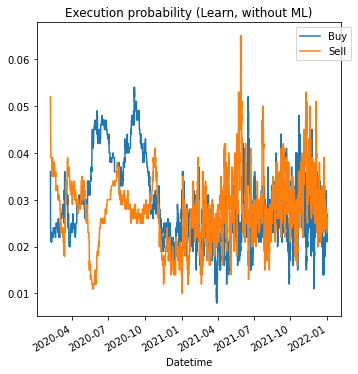

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


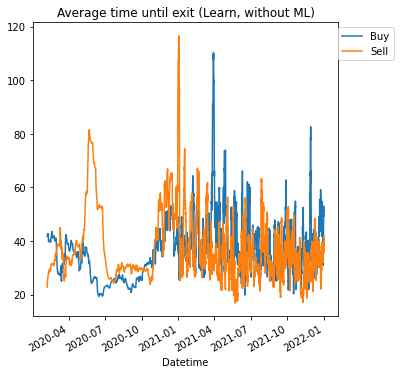

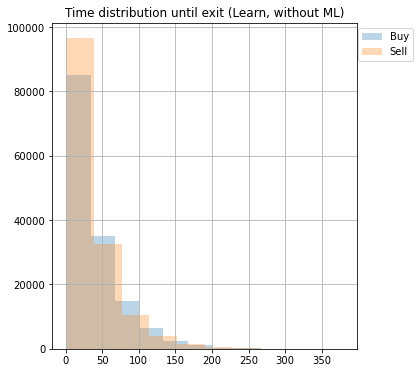

毎時刻、この執行方法でトレードした場合の累積リターン


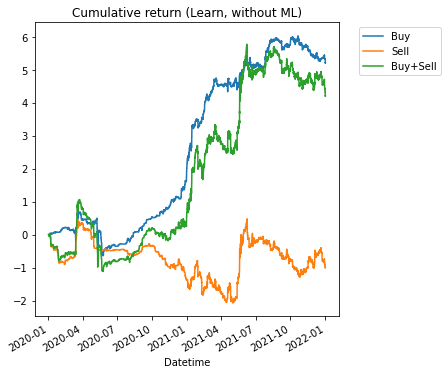

買いリターン 521.10% 売りリターン -100.23% 合計リターン 420.87%
バーの数 145964本, 買い 3917回, 売り 4208回, 買った時のリターン平均 0.133 %, 売った時のリターン平均 -0.024 %
リターンが0以上になる率 57.48923076923077 %
買いエントリーの統計量
count    3916.000000
mean        0.001331
std         0.018371
min        -0.158636
25%        -0.005202
50%         0.001678
75%         0.007521
max         0.191940
Name: y_buy_executed, dtype: float64
売りエントリーの統計量
count    4208.000000
mean       -0.000238
std         0.018679
min        -0.230273
25%        -0.006237
50%         0.001625
75%         0.007399
max         0.158826
Name: y_sell_executed, dtype: float64


In [7]:
# Optunaの最適化結果に基づいて、学習区間でのパフォーマンス (MLフィルタ適応前) を表示
df_dollar_optimized = pd.read_pickle('df_dollar_10000000_ohlcv_learn.pkl')
df_dollar_optimized = calc_buysell(df_dollar_optimized, pips = 1, atr_mux = atr_mux)

# すべての行で売買するべきである、としておく
df_dollar_optimized['y_pred_buy'] = 1.0
df_dollar_optimized['y_pred_sell'] = 1.0

display_performance(df_dollar_optimized, 'Learn, without ML')

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


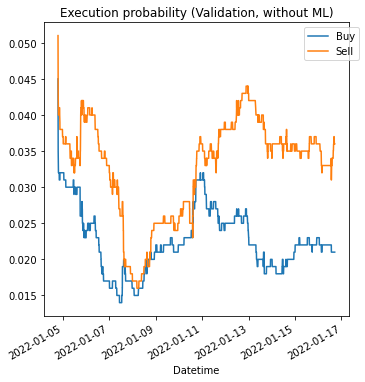

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


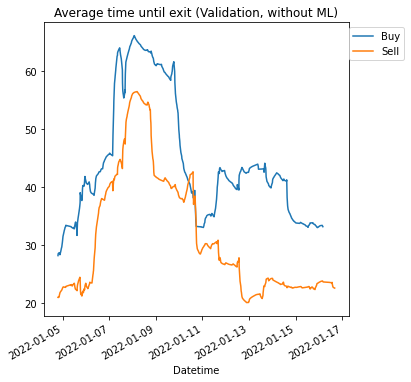

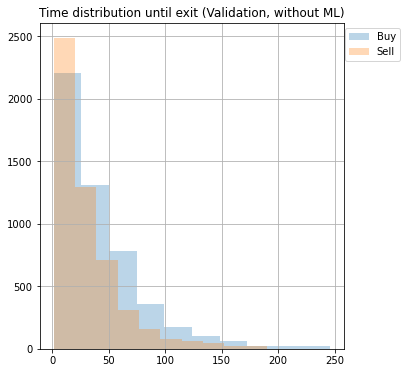

毎時刻、この執行方法でトレードした場合の累積リターン


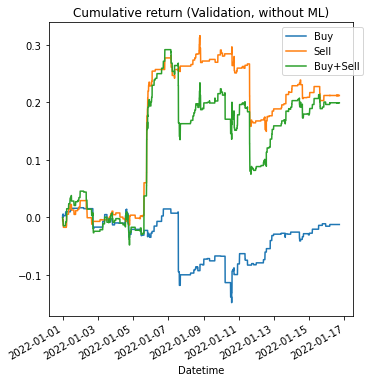

買いリターン -1.27% 売りリターン 21.17% 合計リターン 19.91%
バーの数 5191本, 買い 133回, 売り 191回, 買った時のリターン平均 -0.010 %, 売った時のリターン平均 0.116 %
リターンが0以上になる率 59.5679012345679 %
買いエントリーの統計量
count    133.000000
mean      -0.000095
std        0.009758
min       -0.045885
25%       -0.003068
50%        0.001874
75%        0.005028
max        0.018512
Name: y_buy_executed, dtype: float64
売りエントリーの統計量
count    183.000000
mean       0.001157
std        0.008817
min       -0.029665
25%       -0.003150
50%        0.001964
75%        0.005691
max        0.028216
Name: y_sell_executed, dtype: float64


In [8]:
# Optunaの最適化結果に基づいて、バリデーション区間でのパフォーマンス (MLフィルタ適応前) を表示
df_dollar_validation = pd.read_pickle('df_dollar_10000000_ohlcv_validation.pkl')
df_dollar_validation = calc_buysell(df_dollar_validation, pips = 1, atr_mux = atr_mux)
display_performance(df_dollar_validation, 'Validation, without ML')

In [9]:
# Richmanbtcさんのチュートリアルから取った特徴量計算関数
def calc_features(df):
    open = df['Open']
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['dollar_buy_volume'] + df['dollar_sell_volume']
    liquidation = df['dollar_liquidation_buy_volume'] + df['dollar_liquidation_sell_volume']
    
    hilo = (high + low) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)
    
    # 一部ドルバー由来の特徴量を追加
    df['CLOSE_LOGDIFF'] = np.log1p(df['Close']).diff()
    df['BUY_DOLLAR_VOLUME_LOGDIFF'] = np.log1p(df['dollar_buy_volume']).diff()
    df['SELL_DOLLAR_VOLUME_LOGDIFF'] = np.log1p(df['dollar_sell_volume']).diff()
    df['BUY_DOLLAR_LIQUIDATION_LOGDIFF'] = np.log1p(df['dollar_liquidation_buy_volume']).diff()
    df['SELL_DOLLAR_LIQUIDATION_LOGDIFF'] = np.log1p(df['dollar_liquidation_sell_volume']).diff()
    df['BUY_RATIO'] = df['dollar_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['SELL_RATIO'] = df['dollar_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_BUY_RATIO'] = df['dollar_liquidation_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_SELL_RATIO'] = df['dollar_liquidation_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['BUY_RATIO_LOGDIFF'] = np.log1p(df['BUY_RATIO']).diff()
    df['SELL_RATIO_LOGDIFF'] = np.log1p(df['SELL_RATIO']).diff()
    df['LIQUIDATION_BUY_RATIO_LOGDIFF'] = np.log1p(df['LIQUIDATION_BUY_RATIO']).diff()
    df['LIQUIDATION_SELL_RATIO_LOGDIFF'] = np.log1p(df['LIQUIDATION_SELL_RATIO']).diff()
    df['TIME'] = df.index
    df['DELTA_TIME'] = df['TIME'].diff()
    df['DELTA_TIME'] = df['DELTA_TIME'].view(float)
    df['DELTA_TIME^-1'] = 1.0 / df['DELTA_TIME']

    return df.dropna()

In [10]:
# すべての特徴量を学習に利用する
features = sorted([
#    'ADX',
#    'ADXR',
#    'APO',
#    'AROON_aroondown',
#    'AROON_aroonup',
#    'AROONOSC',
#    'CCI',
#    'DX',
#    'MACD_macd',
#    'MACD_macdsignal',
#    'MACD_macdhist',
#    'MFI',
#    'MINUS_DI',
#    'MINUS_DM',
#    'MOM',
#    'PLUS_DI',
#    'PLUS_DM',
#    'RSI',
#    'STOCH_slowk',
#    'STOCH_slowd',
#    'STOCHF_fastk',
#    'STOCHRSI_fastd',
#    'ULTOSC',
#    'WILLR',
#    'ADOSC',
#    'NATR',
#    'HT_DCPERIOD',
#    'HT_DCPHASE',
#    'HT_PHASOR_inphase',
#    'HT_PHASOR_quadrature',
#    'HT_TRENDMODE',
#    'BETA',
#    'LINEARREG',
#    'LINEARREG_ANGLE',
#    'LINEARREG_INTERCEPT',
#    'LINEARREG_SLOPE',
#    'STDDEV',
#    'BBANDS_upperband',
#    'BBANDS_middleband',
#    'BBANDS_lowerband',
#    'DEMA',
#    'EMA',
#    'HT_TRENDLINE',
#    'KAMA',
#    'MA',
#    'MIDPOINT',
#    'T3',
#    'TEMA',
#    'TRIMA',
#    'WMA',
    
#    'CLOSE_LOGDIFF',
#    'BUY_DOLLAR_VOLUME_LOGDIFF',
#    'SELL_DOLLAR_VOLUME_LOGDIFF',
#    'BUY_DOLLAR_LIQUIDATION_LOGDIFF',
#    'SELL_DOLLAR_LIQUIDATION_LOGDIFF',
    'BUY_RATIO',
    'SELL_RATIO',
    'LIQUIDATION_BUY_RATIO',
    'LIQUIDATION_SELL_RATIO',
#    'BUY_RATIO_LOGDIFF',
#    'SELL_RATIO_LOGDIFF',
#    'LIQUIDATION_BUY_RATIO_LOGDIFF',
#    'LIQUIDATION_SELL_RATIO_LOGDIFF',
#    'DELTA_TIME',
#    'DELTA_TIME^-1'
])

print(features)

['BUY_RATIO', 'LIQUIDATION_BUY_RATIO', 'LIQUIDATION_SELL_RATIO', 'SELL_RATIO']


In [11]:
# トレーニングデータに売買アクションと特徴量を追加
df_dollar = pd.read_pickle('df_dollar_10000000_ohlcv_learn.pkl')
df_dollar = calc_buysell(df_dollar, pips = 1, atr_mux = atr_mux)
df_dollar = calc_features(df_dollar)
df_dollar = df_dollar.dropna()

# トレーニングデータを使ってモデルをトレーニングする
df_dollar = pd.read_pickle('df_dollar_10000000_ohlcv_learn_y.pkl')
model_buy = lgb.LGBMRegressor(n_jobs=-1, random_state=1, importance_type='gain')
model_sell = lgb.LGBMRegressor(n_jobs=-1, random_state=1, importance_type='gain')
model_buy.fit(df_dollar[features], df_dollar['y_buy'])
model_sell.fit(df_dollar[features], df_dollar['y_sell'])

# モデルを利用して予測した結果を入れておく
df_dollar['y_pred_buy'] = model_buy.predict(df_dollar[features])
df_dollar['y_pred_sell'] = model_sell.predict(df_dollar[features])

# トレーニングしたモデルを保存
joblib.dump(model_buy, 'model_y_buy.xz', compress=True) 
joblib.dump(model_sell, 'model_y_sell.xz', compress=True)

['model_y_sell.xz']

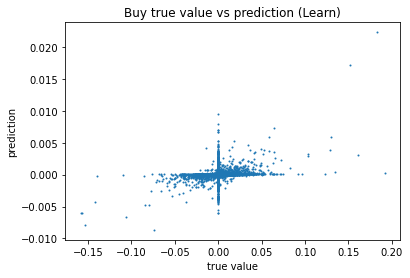

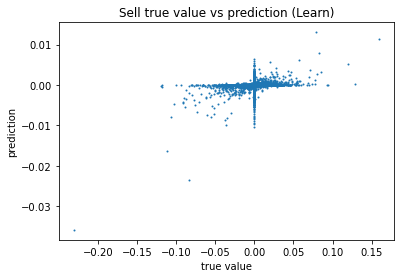

In [18]:
# 学習区間でのリターンの真値とリターンの予測値を散布図で比較する
# 買いモデル
plt.scatter(df_dollar['y_buy'], df_dollar['y_pred_buy'], s=1)
plt.title("Buy true value vs prediction (Learn)")
plt.xlabel("true value")
plt.ylabel("prediction")
plt.show()

# 売りモデル
plt.scatter(df_dollar['y_sell'], df_dollar['y_pred_sell'], s=1)
plt.title("Sell true value vs prediction (Learn)")
plt.xlabel("true value")
plt.ylabel("prediction")
plt.show()

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


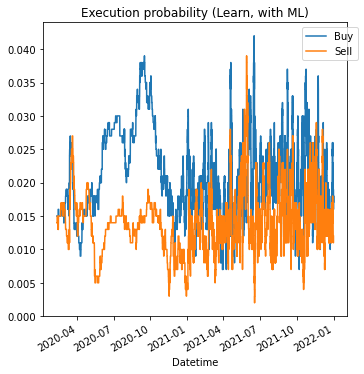

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


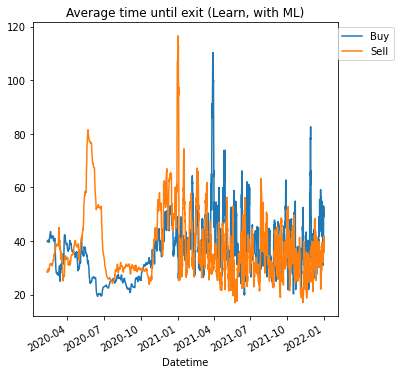

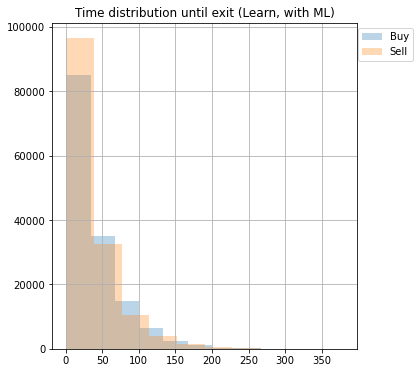

毎時刻、この執行方法でトレードした場合の累積リターン


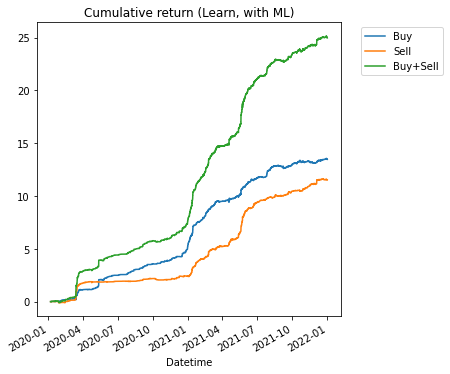

買いリターン 1346.05% 売りリターン 1151.96% 合計リターン 2498.01%
バーの数 145848本, 買い 2956回, 売り 2136回, 買った時のリターン平均 0.455 %, 売った時のリターン平均 0.539 %
リターンが0以上になる率 66.73212882953653 %
買いエントリーの統計量
count    2956.000000
mean        0.004554
std         0.016513
min        -0.076399
25%        -0.002836
50%         0.002951
75%         0.009301
max         0.191940
Name: y_buy_executed, dtype: float64
売りエントリーの統計量
count    2136.000000
mean        0.005393
std         0.015834
min        -0.080756
25%        -0.001524
50%         0.003625
75%         0.010160
max         0.158826
Name: y_sell_executed, dtype: float64


In [13]:
# 学習区間でMLフィルタ適応後のパフォーマンスを確認して、MLがきちんと動いていることを確認
df_dollar = pd.read_pickle('df_dollar_10000000_ohlcv_learn.pkl')
df_dollar = calc_buysell(df_dollar, pips = 1, atr_mux = atr_mux)
df_dollar = calc_features(df_dollar)
df_dollar.loc[:, 'y_pred_buy'] = model_buy.predict(df_dollar[features])
df_dollar.loc[:, 'y_pred_sell'] = model_sell.predict(df_dollar[features])

# 予測が正でないフレームのbuy_executedをすべて0にしておく
df_dollar.loc[df_dollar['y_pred_buy'] <= 0, 'buy_executed'] = 0.0
df_dollar.loc[df_dollar['y_pred_sell'] <= 0, 'sell_executed'] = 0.0

# パフォーマンスの表示
display_performance(df_dollar, 'Learn, with ML')

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


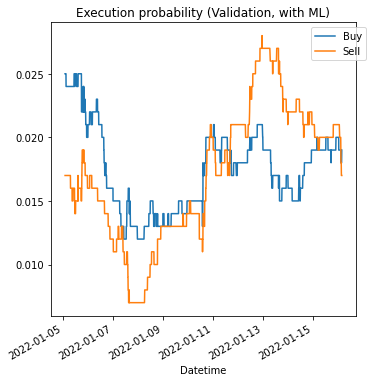

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


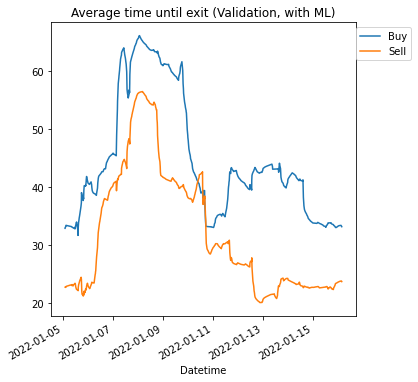

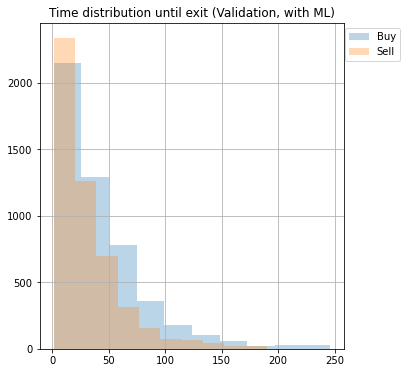

毎時刻、この執行方法でトレードした場合の累積リターン


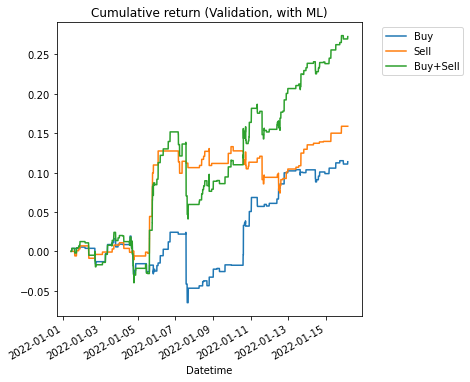

買いリターン 11.38% 売りリターン 15.89% 合計リターン 27.27%
バーの数 4989本, 買い 93回, 売り 83回, 買った時のリターン平均 0.122 %, 売った時のリターン平均 0.191 %
リターンが0以上になる率 65.9090909090909 %
買いエントリーの統計量
count    93.000000
mean      0.001224
std       0.009302
min      -0.038590
25%      -0.002068
50%       0.002958
75%       0.005908
max       0.018512
Name: y_buy_executed, dtype: float64
売りエントリーの統計量
count    83.000000
mean      0.001914
std       0.008945
min      -0.029665
25%      -0.002571
50%       0.003018
75%       0.006201
max       0.028216
Name: y_sell_executed, dtype: float64


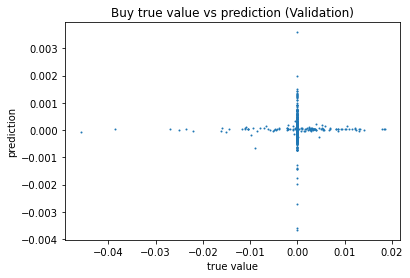

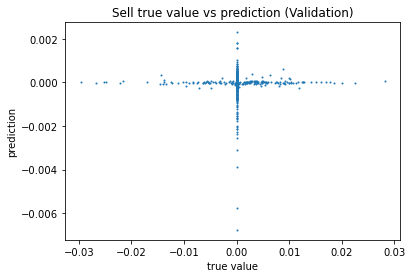

In [19]:
# バリデーション区間でMLフィルタ適応後のパフォーマンスを確認する
df_dollar_validation = pd.read_pickle('df_dollar_10000000_ohlcv_validation.pkl')
df_dollar_validation = calc_buysell(df_dollar_validation, pips = 1, atr_mux = atr_mux)
df_dollar_validation = calc_features(df_dollar_validation)
df_dollar_validation.loc[:, 'y_pred_buy'] = model_buy.predict(df_dollar_validation[features])
df_dollar_validation.loc[:, 'y_pred_sell'] = model_sell.predict(df_dollar_validation[features])

# 予測が正でないフレームのbuy_executedをすべて0にしておく
df_dollar_validation.loc[df_dollar_validation['y_pred_buy'] <= 0, 'buy_executed'] = 0.0
df_dollar_validation.loc[df_dollar_validation['y_pred_sell'] <= 0, 'sell_executed'] = 0.0

# パフォーマンスの表示
display_performance(df_dollar_validation, 'Validation, with ML')

# リターンとリターンの予測値を散布図で比べてみる
plt.scatter(df_dollar_validation['y_buy'], df_dollar_validation['y_pred_buy'], s=1)
plt.title("Buy true value vs prediction (Validation)")
plt.xlabel("true value")
plt.ylabel("prediction")
plt.show()

plt.scatter(df_dollar_validation['y_sell'], df_dollar_validation['y_pred_sell'], s=1)
plt.title("Sell true value vs prediction (Validation)")
plt.xlabel("true value")
plt.ylabel("prediction")
plt.show()

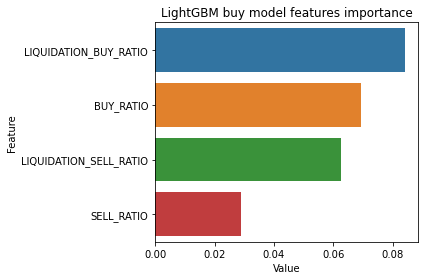

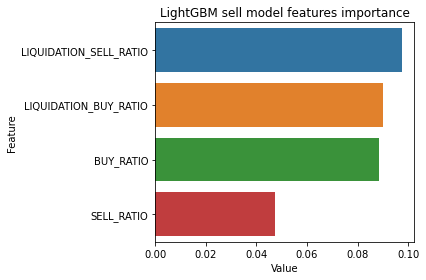

In [15]:
# 買いモデルの特徴量の重要度を表示する
feature_imp = pd.DataFrame(sorted(zip(model_buy.feature_importances_, features)), columns=['Value','Feature'])
#plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM buy model features importance')
plt.tight_layout()
plt.show()

# 売りモデルの特徴量の重要度を表示する
feature_imp = pd.DataFrame(sorted(zip(model_sell.feature_importances_, features)), columns=['Value','Feature'])
#plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM sell model features importance')
plt.tight_layout()
plt.show()